In [187]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2  #, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
from matplotlib.patches import Rectangle

In [188]:

points_per_frame = {
    #600: [ [[581, 401]], [[533, 414]], [[598, 438]] ],
    #598: [ [[538, 398]], [[600, 434]], [[573, 389]] ],
    #594: [ [[542, 396]], [[598, 422]], [[556, 386]] ],
    #589: [ [[522, 401]], [[566, 387]], [[602, 433]] ],
    580: [ [[430, 561]], [[438, 552]], [[451, 572]] ]
    # [500, 350, 610, 450]
}


PARENT_DIR = os.path.dirname(os.getcwd())
# PATH_IMAGES_F3 = os.path.join(parent, "videos")

In [189]:
seismic_volume = np.load("./seismic_data/F3_amplitude.npy")  # [:, 560:630, 357:]

seismic_volume = 255 * (seismic_volume - seismic_volume.min()) / (seismic_volume.max() - seismic_volume.min())
seismic_volume = seismic_volume.astype(np.uint8)

seismic_volume.shape

(651, 951, 462)

In [190]:
def resize_image(Img):
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))

    if Img.shape[0]<1024:
        Img = np.concatenate([Img,np.zeros([1024 - Img.shape[0], Img.shape[1],3],dtype=np.uint8)],axis=0)

    if Img.shape[1]<1024:
        Img = np.concatenate([Img, np.zeros([Img.shape[0] , 1024 - Img.shape[1], 3], dtype=np.uint8)],axis=1)
    return Img



In [191]:
def show_image(image, mask, frame, points=None, bboxes=None):
    fig, ax = plt.subplots()
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    ax.imshow(image)
    ax.imshow(mask_image)
    ax.set_title(f"Frame {frame}")
    if points is not None:

        for point in points:
            ax.scatter(point[0, 1], point[0, 0], color='green', marker='*', s=100,
                        edgecolor='white', linewidth=1.25)

    if bboxes is not None:
        for box in bboxes:
            w0, h0, w1, h1 = tuple(box)
            rect = Rectangle((w0, h0), w1-w0, h1-h0, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
    plt.show()
    

In [192]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

# Load model you need to have pretrained model already made
sam2_checkpoint = os.path.join(PARENT_DIR, "checkpoints", "sam2.1_hiera_tiny.pt") # path to model weight
model_cfg = os.path.join(PARENT_DIR, "sam2", "configs", "sam2.1", "sam2.1_hiera_t.yaml") # model config

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load("./checkpoints/best_model.pth"))

<All keys matched successfully>

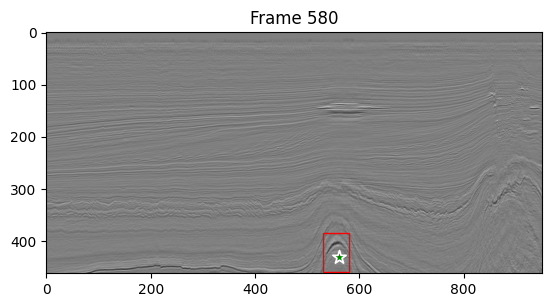

In [193]:
ref_frame = 580

selected_points = np.array(points_per_frame[ref_frame][0])

if len(selected_points.shape) < 3:
    selected_points = selected_points.reshape(
        selected_points.shape[0], 1, selected_points.shape[1])

inline = seismic_volume[ref_frame].T
arr_image = np.stack((inline, inline, inline), axis=2)
image = Image.fromarray(arr_image, "RGB")

input_boxes = np.array([[530, 384, 580, 460]
                        for _ in range(len(selected_points))])

show_image(arr_image, np.zeros((arr_image.shape[0], arr_image.shape[1])),
            ref_frame, selected_points, input_boxes)

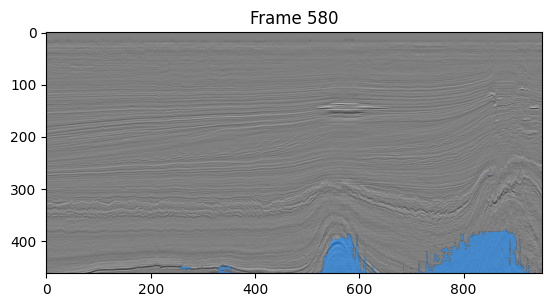

In [194]:

with torch.no_grad():
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords = selected_points,
        point_labels = np.ones([selected_points.shape[0], 1]),
        box=input_boxes,
        multimask_output=False,
    )
    # masks = masks[:, 0]
    # logits = logits[:, 0]

    shorted_mask = masks[ np.argsort(scores[0])][::-1][0]
    best_mask_ref = logits[np.argsort(scores[0])][::-1][0]

    show_image(arr_image, shorted_mask, ref_frame)

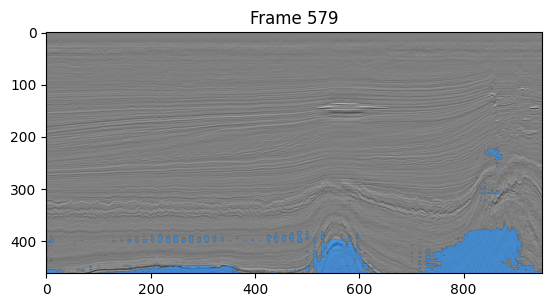

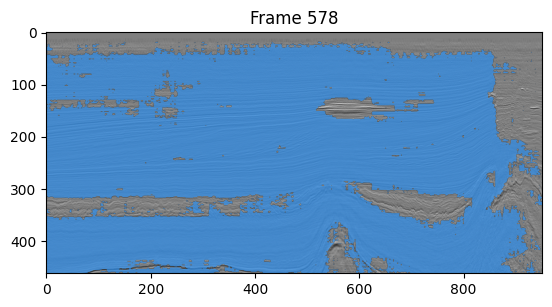

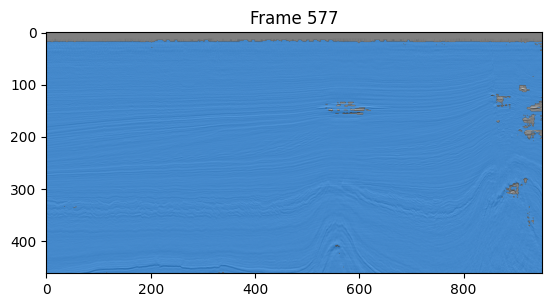

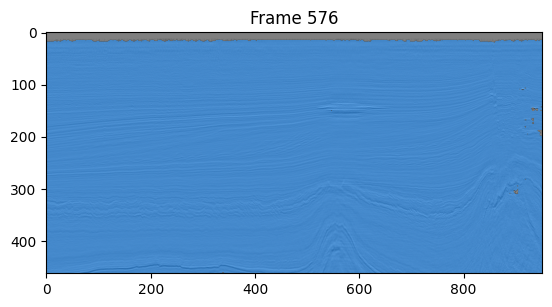

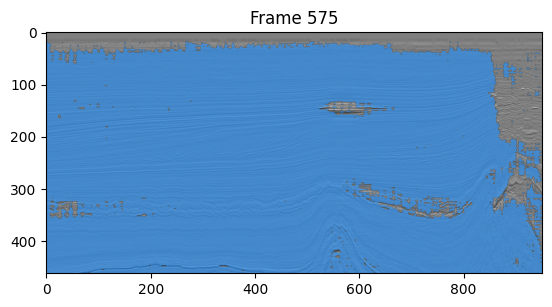

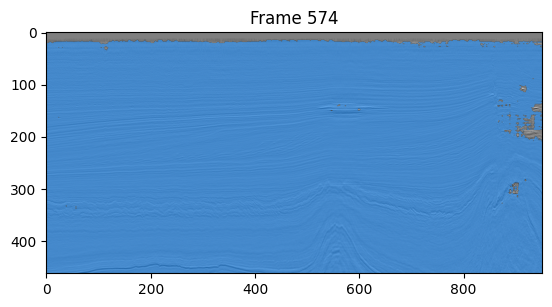

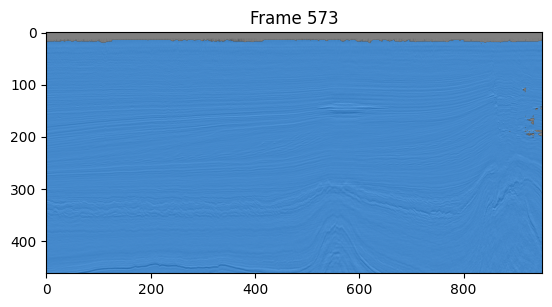

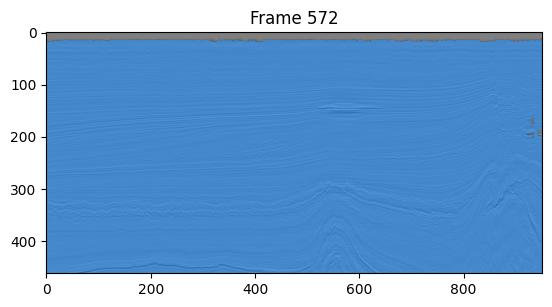

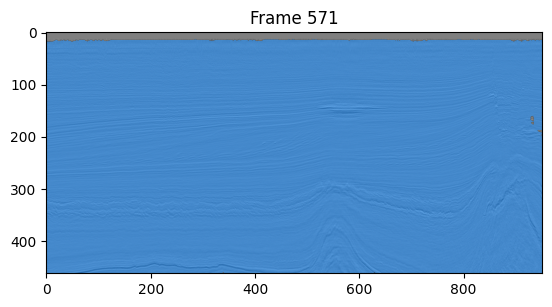

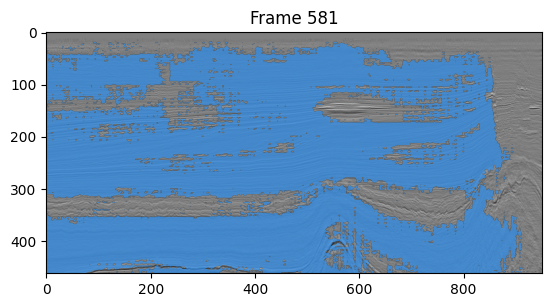

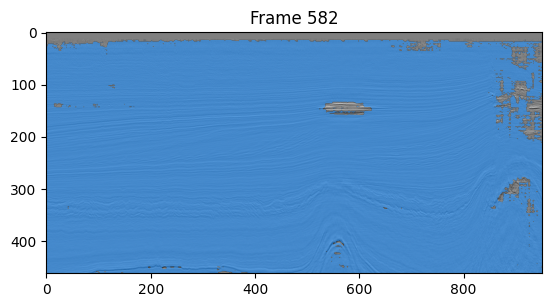

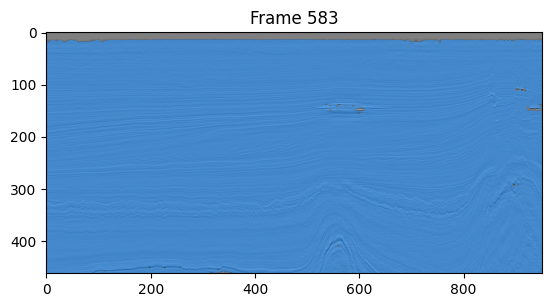

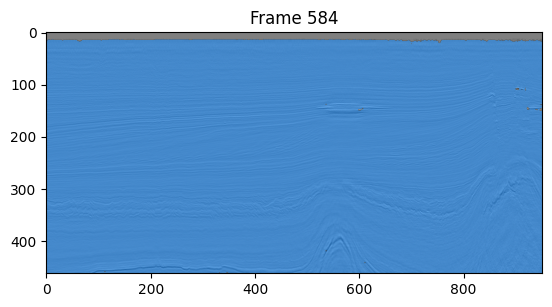

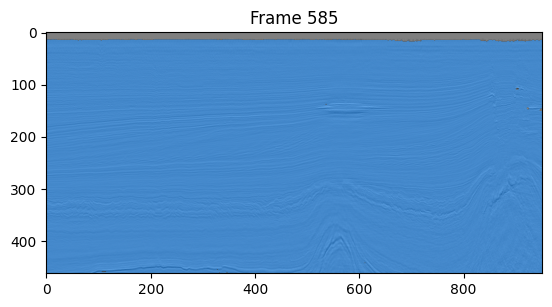

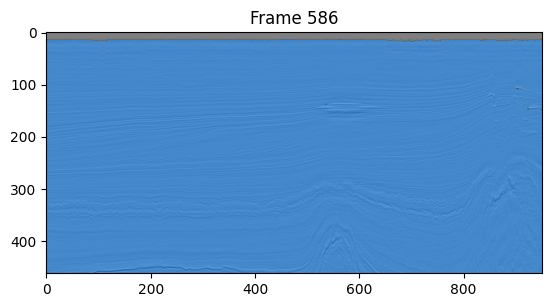

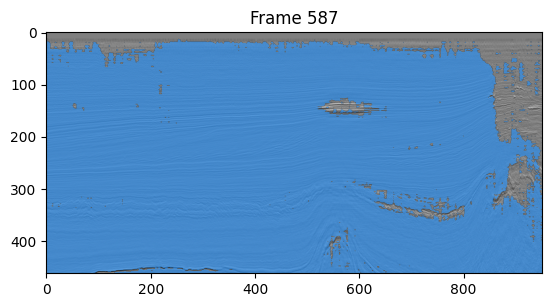

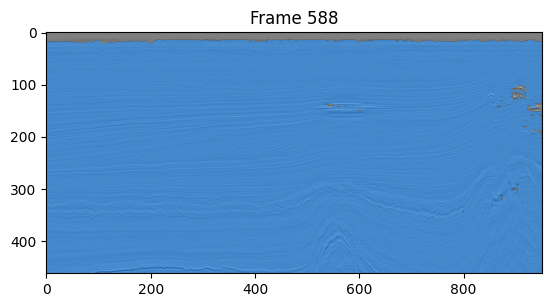

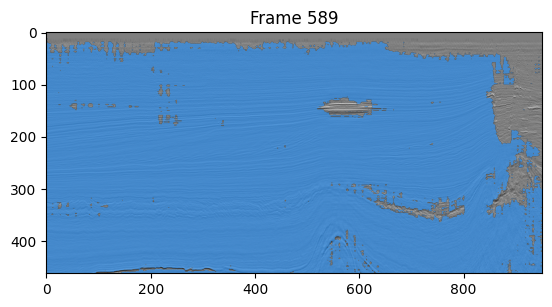

In [195]:
def predict_next_frame(predictor, best_mask, frame, seismic_volume):
    inline = seismic_volume[frame].T
    arr_image = np.stack((inline, inline, inline), axis=2)
    image = Image.fromarray(arr_image, "RGB")

    predictor.set_image(image)
        
    masks, scores, logits = predictor.predict(
        mask_input = best_mask[None, :, :],
        multimask_output=False
    )
    # ind_max = np.argmax(scores)
    best_mask = logits[0]
    # best_mask = logits[ind_max, :, :]

    show_image(np.array(image), masks[0], frame)
    # show_image(np.array(image), masks[ind_max], frame)

    return best_mask


size_propagation = 10

with torch.no_grad():
    best_mask = np.copy(best_mask_ref)

    for frame in range(ref_frame-1, ref_frame-size_propagation, -1):
        best_mask = predict_next_frame(predictor, best_mask, frame, seismic_volume)

    best_mask = np.copy(best_mask_ref)

    for frame in range(ref_frame+1, ref_frame+size_propagation):
        best_mask = predict_next_frame(predictor, best_mask, frame, seismic_volume)